In [ ]:
# # Required environment: Python 3.10 or more

# # 🧰 Install required packages (run this cell only once per environment setup)
# # Install the core IBL tools: ONE-api (data access), ibllib (IBL tools),
# !pip install ONE-api ibllib 

# # Install brainbox (analysis utilities)
# !pip install git+https://github.com/int-brain-lab/ibllib.git

# # Install the scientific and plotting libraries
# !pip install matplotlib seaborn pandas numpy scipy

In [ ]:
# 🧪 Core scientific stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 📊 Stats
from scipy.stats import pearsonr

# 🧠 IBL data access
from one.api import ONE
from brainbox.io.one import SpikeSortingLoader, SessionLoader
from brainbox.behavior.training import compute_performance
from brainbox.population.decode import get_spike_counts_in_bins
import scipy.io as sio  # For saving

# --- Load session ---
one = ONE(base_url='https://openalyx.internationalbrainlab.org')
pid = '1e176f17-d00f-49bb-87ff-26d237b525f1'
eid, pname = one.pid2eid(pid)

# Load trial info
trials = one.load_object(eid, 'trials', collection='alf')
performance, contrasts, n_contrasts = compute_performance(trials)

# Load spike sorting data
ssl = SpikeSortingLoader(eid=eid, pname=pname, one=one)
spikes, clusters, channels = ssl.load_spike_sorting()
clusters = ssl.merge_clusters(spikes, clusters, channels)



In [21]:
# --- Filtering setup ---
target_region = 'LP'         # Brain region of interest
target_contrast = 0.0        # e.g. 0% contrast
target_prior = 0.8           # Prior probability of left
flag_good_quality = False    # Only include good quality neurons

# --- Neuron selection ---
region_mask = clusters['acronym'] == target_region

# Ensure both masks are the same length (equal to n_neurons)
n_neurons = len(clusters['acronym'])
if flag_good_quality:
    quality_mask = clusters['label'] == 1
else:
    quality_mask = np.ones(n_neurons, dtype=bool)

valid_cluster_mask = region_mask & quality_mask
valid_cluster_ids = clusters['cluster_id'][valid_cluster_mask]
print(f"# Neurons in {target_region}: {len(valid_cluster_ids)}")

# --- Trial selection ---
trial_mask = (trials['contrastLeft'] == target_contrast) & \
             (trials['probabilityLeft'] == target_prior)
valid_trial_times = trials['stimOn_times'][trial_mask]
print(f"# Valid trials: {len(valid_trial_times)}")

# --- Define spike count window: 100–200 ms after stim onset ---
time_bins = np.stack([valid_trial_times + 0.1, valid_trial_times + 0.2], axis=1)

# --- Filter spikes for selected neurons ---
is_valid_spike = np.isin(spikes.clusters, valid_cluster_ids)
spike_times = spikes.times[is_valid_spike]
spike_clusters = spikes.clusters[is_valid_spike]

# --- Compute spike counts using brainbox ---
from brainbox.population.decode import get_spike_counts_in_bins

# Get spike counts for ALL clusters present in spike_clusters
spike_counts, all_cluster_ids = get_spike_counts_in_bins(spike_times, spike_clusters, time_bins)

# all_cluster_ids: (n_clusters,)  — tells you the order of neurons in spike_counts
# spike_counts: (n_trials, n_clusters)

# Now keep only the valid neurons
# Find the indices of your desired neurons in the returned cluster list
valid_idx = np.where(np.isin(all_cluster_ids, valid_cluster_ids))[0]

# Filter to valid neurons and transpose: shape becomes (n_neurons, n_trials)
spike_counts = spike_counts[:, valid_idx].T

choice_values = trials['choice'][trial_mask]
valid_choice_mask = choice_values != 0

spike_counts = spike_counts[:, valid_choice_mask]
choice_values = choice_values[valid_choice_mask]

# Neurons in LP: 281
# Valid trials: 24


IndexError: index 24 is out of bounds for axis 1 with size 24

Spike count matrix shape (neurons × trials): (24, 281)


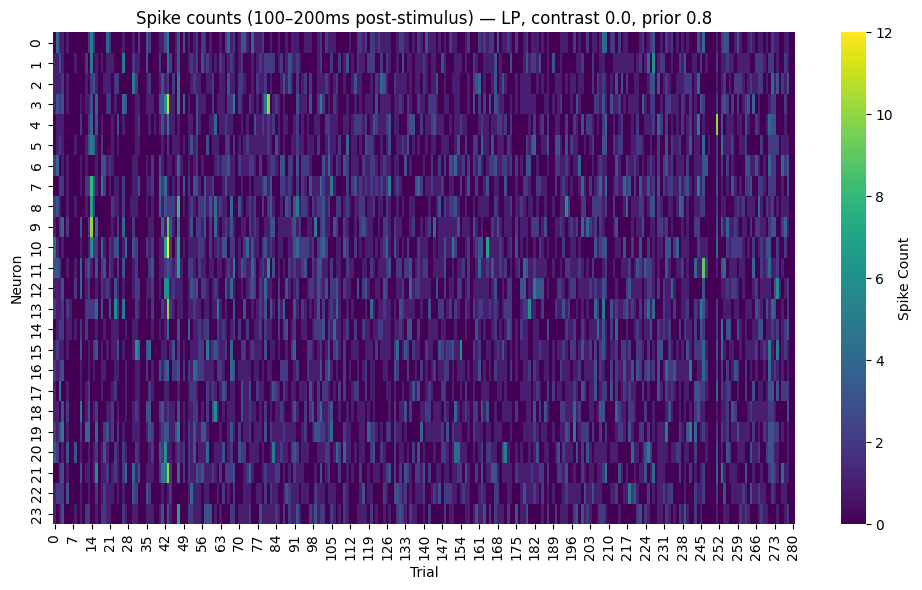

In [4]:
# --- Compute spike counts (shape: trials × neurons) ---
# spike_counts = get_spike_counts_in_bins(spike_times, spike_clusters, time_bins)
spike_counts, spike_cluster_ids = get_spike_counts_in_bins(spike_times, spike_clusters, time_bins)
spike_counts = spike_counts.T  # transpose to neurons × trials

print("Spike count matrix shape (neurons × trials):", spike_counts.shape)

# --- Visualize ---
plt.figure(figsize=(10, 6))
sns.heatmap(spike_counts, cmap='viridis', cbar_kws={'label': 'Spike Count'})
plt.xlabel("Trial")
plt.ylabel("Neuron")
plt.title(f"Spike counts (100–200ms post-stimulus) — {target_region}, contrast {target_contrast}, prior {target_prior}")
plt.tight_layout()
plt.show()

In [ ]:

# Format prior label
prior_label = {0.2: 'L', 0.5: 'N', 0.8: 'R'}.get(target_prior, f"P{int(target_prior*100)}")

# Format contrast as two-digit string
contrast_str = f"{int(target_contrast * 100):02d}"

# Get matrix shape: neurons × trials
n_neurons, n_trials = spike_counts.shape

# Construct filename
filename = f"spikeCount_{target_region}_C{contrast_str}_{prior_label}_N{n_neurons}_T{n_trials}.mat"

# Save to .mat file (MATLAB-compatible)
sio.savemat(filename, {'spike_counts': spike_counts})

print(f"Saved spike count matrix to MATLAB file: {filename}")

Saved spike count matrix to MATLAB file: spikeCount_LP_C00_L_N24_T281.mat


Behavior responses shape: (24,)
Unique responses: [-1.  0.  1.]


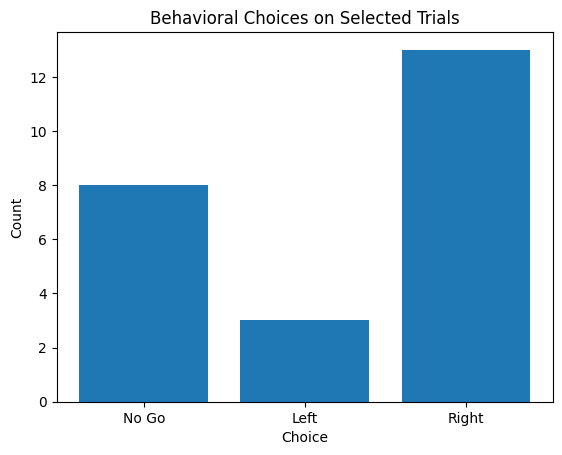

In [23]:
# Step 1: Select trials based on contrast and prior (already done)
trial_mask = (trials['contrastLeft'] == target_contrast) & \
             (trials['probabilityLeft'] == target_prior)

# Step 2: Extract behavioral responses for these trials
# For example, using the 'choice' field
behavior_responses = trials['choice'][trial_mask]  # shape: (n_trials,)

# Optional: check values
print("Behavior responses shape:", behavior_responses.shape)
print("Unique responses:", np.unique(behavior_responses))

import matplotlib.pyplot as plt

plt.hist(behavior_responses, bins=np.arange(-1.5, 2.5, 1), rwidth=0.8)
plt.xticks([-1, 0, 1], labels=['No Go', 'Left', 'Right'])
plt.xlabel("Choice")
plt.ylabel("Count")
plt.title("Behavioral Choices on Selected Trials")
plt.show()


# save this vector to a mat file
sio.savemat("behavior_responses.mat", {"behavior_responses": behavior_responses})

# Exploring trials data

In [ ]:
#  Example 1. Computing behavioral performance
from brainbox.behavior.training import compute_performance

# compute performance
performance, contrasts, n_contrasts = compute_performance(trials)

# compute performance expressed as probability of choosing right
# performance, contrasts, n_contrasts = compute_performance(trials, prob_right=True)

# compute performance during 0.8 biased block
# performance, contrasts, n_contrasts = compute_performance(trials, block=0.8)

# print important performance stats
print(f'Performance: {np.round(performance,2)}')
print(f'Contrasts: {contrasts}')
print(f'Number of Contrasts: {n_contrasts}')

# Inspect content of trials
print(trials.keys())
# dict_keys(['goCueTrigger_times', 'stimOff_times', 'contrastLeft', 'probabilityLeft', 'feedbackType', 'feedback_times', 'response_times', 'stimOn_times', 'rewardVolume', 'firstMovement_times', 'choice', 'contrastRight', 'goCue_times', 'intervals'])

# check the shape of each key of "trials"
# for key in trials.keys():
#     print(f"{key}: {trials[key].shape}")

indTrial = 0
# check the content of each key for trial indTrial
# goCueTrigger_times: (indTrial,) - time of the go cue trigger for trial indTrial
print('Go cue trigger time: ', trials.goCueTrigger_times[indTrial])
# stimOff_times: (indTrial,)
print('Stim off time: ', trials.stimOff_times[indTrial])
# contrastLeft: (indTrial,)
print('Contrast left: ',    trials.contrastLeft[indTrial])
# probabilityLeft: (indTrial,)
print('Probability left: ', trials.probabilityLeft[indTrial])
# feedbackType: (indTrial,)
print('Feedback type: ', trials.feedbackType[indTrial])


In [ ]:
# Example 2. Filtering trials
from brainbox.task.trials import find_trial_ids

# find index for stim right trials ordered by trial number
trial_id, _ = find_trial_ids(trials, side='right', choice='all', order='trial num')

# find index for correct, stim left, 100% contrast trials ordered by reaction time
# trial_id, _ = find_trial_ids(trials, side='left', choice='correct', contrast=[1], order='reaction time')

# find index for correct trials ordered by trial number sorted by stimulus side
# trial_id, _ = find_trial_ids(trials, side='left', choice='correct', order='reaction time', sort='side')


In [ ]:
# Example 3. Plotting psychometric curve
from brainbox.behavior.training import plot_psychometric

fig, ax = plot_psychometric(trials)

# Load spikeSorting data


In [ ]:
# instantiate the spike sorting loader using the session unique identifier eid
ssl = SpikeSortingLoader(eid=eid, pname=pname, one=one)
spikes, clusters, channels = ssl.load_spike_sorting()
clusters = ssl.merge_clusters(spikes, clusters, channels)


In [ ]:
# print size of spikes
print("Number of spikes:", spikes.times.shape[0])      # Number of spikes
print("Spike times shape:", spikes.times.shape)
print("Spike clusters shape:", spikes.clusters.shape)


# Sample neurons from a certain cluster

In [ ]:
clusters = ssl.merge_clusters(spikes, clusters, channels)
brain_regions = clusters.acronym



In [ ]:
brain_regions = clusters.acronym
print(len(brain_regions))

## Inspect loaded "spikes"

In [ ]:
# check the content of spikes
print(spikes.keys())
# 	•	spikes.times: spike times in seconds
# 	•	spikes.clusters: cluster ID (i.e., neuron ID)
# 	•	spikes.amps: spike amplitude
# 	•	spikes.depths: estimated probe depth for each spike

# Print the shape of the data
print("Number of spikes:", spikes.times.shape[0])      # Number of spikes
print("Spike times shape:", spikes.times.shape)
print("Spike clusters shape:", spikes.clusters.shape)

# raster plot of all neurons on one trial
# spike data
spike_times = spikes.times       # shape: (n_spikes,)
spike_clusters = spikes.clusters # shape: (n_spikes,)

# select a certain trial
trial_idx = 7

# select data from cluster LP
spike_times = spike_times[spike_clusters == 'LP']
spike_clusters = spike_clusters[spike_clusters == 'LP']

# Print the shape of the data at a certain region
print("Number of spikes:", spike_times.shape[0])      # Number of spikes
print("Spike times shape:", spike_times.shape)
print("Spike clusters shape:", spike_clusters.shape)

# cluster data
# cluster_ids = np.unique(spike_clusters)

# trial data
# "trials" was loaded before
trial_starts = trials['intervals'][:, 0]
trial_ends = trials['intervals'][:, 1]

# 1️⃣ Choose a trial index (e.g., trial 5)
t_start = trial_starts[trial_idx]
t_end = trial_ends[trial_idx]

# 2️⃣ Select spikes within that trial
in_trial = (spike_times >= t_start) & (spike_times <= t_end)
trial_spike_times = spike_times[in_trial]
trial_spike_clusters = spike_clusters[in_trial]

# 3️⃣ Get unique neurons (clusters) that spiked in this trial
neurons_in_trial = np.unique(trial_spike_clusters)

# 4️⃣ Build spike trains grouped by neuron, order by depth
raster_data = []
for i, clust_id in enumerate(neurons_in_trial):
    spike_times_for_neuron = trial_spike_times[trial_spike_clusters == clust_id]
    # Get the depth information for this cluster
    cluster_depth = spikes.depths[spikes.clusters == clust_id]
    
    # Align to trial start
    raster_data.append(spike_times_for_neuron - t_start)

# Raster plot
plt.figure(figsize=(10, 6))
plt.eventplot(raster_data, colors='black', lineoffsets=1, linelengths=0.8)
plt.xlabel('Time (s) since trial start')
plt.ylabel('Neuron #')
plt.title(f'Raster plot of spike trains for trial {trial_idx}')
plt.show()


In [ ]:
# Inspect the loaded "clusters"
# print(clusters)
# 1. List unique brain regions in clusters
print(np.unique(clusters.acronym))
# Output: ['BST' 'HY' 'LPO' 'LSr' 'LSv' 'NDB' 'PS' 'STR' 'aco' 'ccb']

# 2. Find cluster IDs corresponding to LP
lp_cluster_ids = np.where(clusters.acronym == 'LP')[0]

In [ ]:
# Calculate firing rate

# first, check if these variables are available
# spikes.times: np.ndarray of spike times (seconds)
# spikes.clusters: np.ndarray of cluster ids (same length as spikes.times)
# stim_onset: float (stimulus onset time in seconds)
# neuron_ids: np.ndarray of unique cluster ids

if not all(var in locals() for var in ['spikes', 'stim_onset', 'neuron_ids']):
    raise ValueError("Required variables are not available.")


In [ ]:
# Example 3: Compute firing rate across session
from brainbox.ephys_plots import image_fr_plot
from iblutil.numerical import bincount2D

time_bin = 0.05 # time bin in seconds
depth_bin = 10 # depth bin in um

# Remove any nan values
kp_idx = np.bitwise_and(~np.isnan(spikes['times']), ~np.isnan(spikes['depths']))

fr, time, depth = bincount2D(spikes['times'][kp_idx], spikes['depths'][kp_idx], time_bin, depth_bin)


In [ ]:
# Example 4: Find clusters labelled as good
good_clusterIDs = clusters['cluster_id'][clusters['label'] == 1]


In [ ]:
# Example 5: Plot a raster for all units
ssl.raster(spikes, channels)
